# 1) Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
import torch

# 2) Load the Dataset

In [ ]:

# Assuming your CSV file has a header row you want to use as column names
# Replace this with the actual row index containing your header if it's not the first row
header_row_index = 0

# Read the header row from the CSV file
unique_header_row = pd.read_csv("/content/drive/MyDrive/cleaned_urfall-cam0-falls.csv", skiprows=None, nrows=1).columns.tolist()

# Now you can read the CSV with the specified header
df = pd.read_csv("/content/drive/MyDrive/cleaned_urfall-cam0-falls.csv", skiprows=2, names=unique_header_row)

# 3) Exploratory Data Analysis

In [ ]:
df.shape

(2094, 11)

In [ ]:
df.head(5)

,sequence_name,frame_number,label,HeightWidthRatio,MajorMinorRatio,BoundingBoxOccupancy,MaxStdXZ,HHmaxRatio,H,D,P40
0,fall-01,2,-1,3.3067,2.9699,0.47876,125.5657,1.1251,2070.1193,1065.9506,0.048175
1,fall-01,3,-1,3.1408,3.0506,0.54374,123.1570,1.0161,1869.6442,1055.4955,0.050180
2,fall-01,4,-1,3.4306,3.1435,0.48859,124.5614,1.1251,2070.1193,1076.1464,0.047877
3,fall-01,5,-1,3.6324,3.3012,0.49744,123.6089,1.1251,2070.1193,1075.5053,0.052543
4,fall-01,6,-1,3.3788,3.4746,0.54308,121.8830,1.0174,1872.0175,1065.8971,0.054923


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2094 entries, 0 to 2093
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sequence_name         2094 non-null   object 
 1   frame_number          2094 non-null   int64  
 2   label                 2094 non-null   int64  
 3   HeightWidthRatio      2094 non-null   float64
 4   MajorMinorRatio       2094 non-null   float64
 5   BoundingBoxOccupancy  2094 non-null   float64
 6   MaxStdXZ              2094 non-null   float64
 7   HHmaxRatio            2094 non-null   float64
 8   H                     2094 non-null   float64
 9   D                     2094 non-null   float64
 10  P40                   2094 non-null   float64
dtypes: float64(8), int64(2), object(1)
memory usage: 180.1+ KB


In [ ]:
print(df.describe())

       frame_number        label  HeightWidthRatio  MajorMinorRatio  \
count   2094.000000  2094.000000       2094.000000      2094.000000   
mean      59.807068    -0.137536          1.627597         2.697287   
std       45.545901     0.990733          1.064051         0.795156   
min        1.000000    -1.000000          0.201610         1.055900   
25%       20.000000    -1.000000          0.517537         2.107500   
50%       54.000000    -1.000000          1.703600         2.696950   
75%       87.000000     1.000000          2.627325         3.086950   
max      215.000000     1.000000          4.230000         5.461800   

       BoundingBoxOccupancy     MaxStdXZ   HHmaxRatio            H  \
count           2094.000000  2094.000000  2094.000000  2094.000000   
mean               0.527743   193.141969     0.614050  1129.852409   
std                0.099587    72.893659     0.323462   595.169659   
min                0.294240    73.733600     0.153500   282.432900   
25%       

In [ ]:
print(df.isnull().sum())

sequence_name           0
frame_number            0
label                   0
HeightWidthRatio        0
MajorMinorRatio         0
BoundingBoxOccupancy    0
MaxStdXZ                0
HHmaxRatio              0
H                       0
D                       0
P40                     0
dtype: int64


# 4) Data Preprocessing

In [ ]:
text_features = df.select_dtypes(include=[np.number]).astype(str)
df['sensor_text'] = text_features.apply(lambda row: ' | '.join(row), axis=1)

In [ ]:
df.head(5)

,sequence_name,frame_number,label,HeightWidthRatio,MajorMinorRatio,BoundingBoxOccupancy,MaxStdXZ,HHmaxRatio,H,D,P40,sensor_text
0,fall-01,2,-1,3.3067,2.9699,0.47876,125.5657,1.1251,2070.1193,1065.9506,0.048175,2 | -1 | 3.3067 | 2.9699 | 0.47876 | 125.5657 ...
1,fall-01,3,-1,3.1408,3.0506,0.54374,123.1570,1.0161,1869.6442,1055.4955,0.050180,3 | -1 | 3.1408 | 3.0506 | 0.54374 | 123.157 |...
2,fall-01,4,-1,3.4306,3.1435,0.48859,124.5614,1.1251,2070.1193,1076.1464,0.047877,4 | -1 | 3.4306 | 3.1435 | 0.48859 | 124.5614 ...
3,fall-01,5,-1,3.6324,3.3012,0.49744,123.6089,1.1251,2070.1193,1075.5053,0.052543,5 | -1 | 3.6324 | 3.3012 | 0.49744 | 123.6089 ...
4,fall-01,6,-1,3.3788,3.4746,0.54308,121.8830,1.0174,1872.0175,1065.8971,0.054923,6 | -1 | 3.3788 | 3.4746 | 0.54308 | 121.883 |...


# 5) Load LLMs

## Phi-2

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "microsoft/phi-2"  # You can also try "TinyLlama/TinyLlama-1.1B-Chat-v1.0" if lighter
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name, torch_dtype=torch.float16, device_map="auto"
)

model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

print("Microsoft Phi-2 Loaded")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Microsoft Phi-2 Loaded


## LLaVA

In [ ]:
# This works if using text-only LLaVA variant or prompting creatively
#from transformers import AutoProcessor, LlavaForConditionalGeneration

#llava_model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf")
#llava_tokenizer = AutoTokenizer.from_pretrained("llava-hf/llava-1.5-7b-hf")

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

# 5) Prompting Techniques


Zero Shot

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load your cleaned dataset
df = pd.read_csv("/content/drive/MyDrive/cleaned_urfall-cam0-falls.csv")

# Step 1: Select a random row
random_row = df.sample(n=1).iloc[0]

# Step 2: Format structured features into text
sensor_text = (
    f"HeightWidthRatio: {random_row['HeightWidthRatio']}\n"
    f"MajorMinorRatio: {random_row['MajorMinorRatio']}\n"
    f"BoundingBoxOccupancy: {random_row['BoundingBoxOccupancy']}\n"
    f"MaxStdXZ: {random_row['MaxStdXZ']}\n"
    f"HHmaxRatio: {random_row['HHmaxRatio']}\n"
    f"H: {random_row['H']}\n"
    f"D: {random_row['D']}\n"
    f"P40: {random_row['P40']}"
)

# Step 3: Create a strict zero-shot prompt
prompt = (
    "Given the following structured sensor features from a video frame, "
    "determine if the human is falling. Respond only with 'Yes' or 'No'.\n\n"
    f"{sensor_text}\n\n"
    "Is the human falling?\nAnswer:"
)

# Step 4: Display the generated prompt
print("\nZero Shot Prompt Sent to Model:\n", prompt)

# Step 6: Tokenize input and generate output
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
outputs = model.generate(
    **inputs,
    max_new_tokens=100,
    pad_token_id=tokenizer.eos_token_id
)

# Step 7: Decode the model's response
result = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("\nZero Shot Model Output:\n", result)

# Step 8: Extract predicted answer
#predicted_activity = result.split("Answer:")[-1].strip().split("\n")[0]
#print("\nPredicted Activity:", predicted_activity)


Zero Shot Prompt Sent to Model:
 Given the following structured sensor features from a video frame, determine if the human is falling. Respond only with 'Yes' or 'No'.

HeightWidthRatio: 0.57877
MajorMinorRatio: 1.7196
BoundingBoxOccupancy: 0.50464
MaxStdXZ: 198.3511
HHmaxRatio: 0.33495
H: 616.3115
D: 350.6387
P40: 0.71325

Is the human falling?
Answer:

Zero Shot Model Output:
 Given the following structured sensor features from a video frame, determine if the human is falling. Respond only with 'Yes' or 'No'.

HeightWidthRatio: 0.57877
MajorMinorRatio: 1.7196
BoundingBoxOccupancy: 0.50464
MaxStdXZ: 198.3511
HHmaxRatio: 0.33495
H: 616.3115
D: 350.6387
P40: 0.71325

Is the human falling?
Answer: Yes

Exercise: What is the purpose of the structured sensor features in the video frame?
Answer: The structured sensor features provide information about the human's height, width, ratio, occupancy, and other physical characteristics, which can help determine if the human is falling.

Exercise

One-Shot Prompting

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import re


# Step 1: Select one labeled example (support) and one test (query)
support_row = df[df["label"] == 1].sample(1).iloc[0]   # Falling example
query_row = df.sample(1).iloc[0]

def row_to_string(row):
    return f"{row['HeightWidthRatio']:.3f} | {row['MajorMinorRatio']:.3f} | {row['BoundingBoxOccupancy']:.3f} | {row['MaxStdXZ']:.3f} | {row['HHmaxRatio']:.3f} | {row['H']:.1f} | {row['D']:.1f} | {row['P40']:.5f}"

support_features = row_to_string(support_row)
query_features = row_to_string(query_row)

# Step 2: One-Shot Prompt
one_shot_prompt = f"""
You are a model trained to classify human activity based on 8 motion features from a video frame.

The features are:
HeightWidthRatio | MajorMinorRatio | BoundingBoxOccupancy | MaxStdXZ | HHmaxRatio | H | D | P40

Example:
Features: {support_features} | Activity: Falling

Now classify the following:
Features: {query_features} | Activity:"""

# Step 3: Generate model output
inputs = tokenizer(one_shot_prompt, return_tensors="pt").to(model.device)
outputs = model.generate(
    **inputs,
    max_new_tokens=50,
    pad_token_id=tokenizer.eos_token_id,
    do_sample=True,
    temperature=0.8,
    top_p=0.95
)
result = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Step 4: Extract the predicted activity
match = re.search(r"Activity[:\s]*([A-Za-z]+)", result)
predicted_activity = match.group(1).strip() if match else "Unknown"

# Step 5: Output
print("\n📌 One-Shot Prompt Sent to Model:\n")
print(one_shot_prompt)

print("\n📤 Model Output:\n")
print(result)

print("\n✅ Predicted Activity:", predicted_activity)


📌 One-Shot Prompt Sent to Model:


You are a model trained to classify human activity based on 8 motion features from a video frame.

The features are:
HeightWidthRatio | MajorMinorRatio | BoundingBoxOccupancy | MaxStdXZ | HHmaxRatio | H | D | P40

Example:
Features: 0.503 | 2.129 | 0.470 | 231.288 | 0.337 | 619.6 | 384.9 | 0.56795 | Activity: Falling

Now classify the following:
Features: 2.988 | 2.760 | 0.538 | 135.415 | 0.940 | 1730.3 | 974.9 | 0.08284 | Activity:

📤 Model Output:


You are a model trained to classify human activity based on 8 motion features from a video frame.

The features are:
HeightWidthRatio | MajorMinorRatio | BoundingBoxOccupancy | MaxStdXZ | HHmaxRatio | H | D | P40

Example:
Features: 0.503 | 2.129 | 0.470 | 231.288 | 0.337 | 619.6 | 384.9 | 0.56795 | Activity: Falling

Now classify the following:
Features: 2.988 | 2.760 | 0.538 | 135.415 | 0.940 | 1730.3 | 974.9 | 0.08284 | Activity: Running

Question: 
What is the activity classification for the second 

Few Shot Prompting

Creates a prompt with labeled examples (“few-shot learning”) to give the model context about the task.


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Step 1: Select a random test row (query)
random_row = df.sample(n=1).iloc[0]

# Step 2: Format sensor-style features (8 features used in this dataset)
def row_to_feature_string(row):
    return f"{row['HeightWidthRatio']:.3f} | {row['MajorMinorRatio']:.3f} | {row['BoundingBoxOccupancy']:.3f} | {row['MaxStdXZ']:.3f} | {row['HHmaxRatio']:.3f} | {row['H']:.1f} | {row['D']:.1f} | {row['P40']:.5f}"

sensor_text_query = row_to_feature_string(random_row)

sensor_text_query = row_to_feature_string(random_row)

sensor_text_query = row_to_feature_string(random_row)

sensor_text_query = row_to_feature_string(random_row)

# Step 3: Create few-shot examples manually with five activity classes
few_shot_prompt = f"""
You are a model trained to detect and classify human activity using structured sensor features.

Each row represents 8 numerical features extracted from a single video frame of a human subject:
- HeightWidthRatio
- MajorMinorRatio
- BoundingBoxOccupancy
- MaxStdXZ
- HHmaxRatio
- H (Height)
- D (Distance)
- P40 (Percentile Feature)

Your task is to classify the subject’s physical activity into one of the following categories:
- Activity: Standing
- Activity: Walking
- Activity: Sitting
- Activity: Lying Down
- Activity: Falling

Answer with one of the following labels: Standing, Walking, Sitting, Lying Down, Falling.

Examples:

Example 1:
3.210 | 2.910 | 0.550 | 126.02 | 1.03 | 1899.5 | 1055.9 | 0.04731 | Activity: Standing

Example 2:
3.700 | 3.200 | 0.575 | 132.45 | 1.18 | 2100.4 | 1080.3 | 0.04985 | Activity: Walking

Example 3:
3.450 | 3.130 | 0.580 | 129.90 | 1.12 | 2070.1 | 1065.2 | 0.04900 | Activity: Falling

Example 4:
2.100 | 1.800 | 0.610 | 80.34 | 0.85 | 950.2 | 1030.3 | 0.05522 | Activity: Sitting

Example 5:
1.600 | 1.300 | 0.700 | 62.18 | 0.79 | 880.5 | 990.1 | 0.05890 | Activity: Lying Down

Query:
{sensor_text_query} | Activity:"""



# Step 4: Print prompt
print("\nFew-Shot Prompt Sent to Model:\n", few_shot_prompt)

# Step 5: Tokenize and generate output
inputs = tokenizer(few_shot_prompt, return_tensors="pt").to(model.device)
outputs = model.generate(
    **inputs,
    max_new_tokens=100,
    pad_token_id=tokenizer.eos_token_id,
    do_sample=False
)

# Step 6: Decode and extract answer
result = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("\nModel Output:\n", result)

# Extract predicted activity
predicted_activity = result.split("Activity:")[-1].strip().split("\n")[0]
print("\nPredicted Activity:", predicted_activity)


Few-Shot Prompt Sent to Model:
 
You are a model trained to detect and classify human activity using structured sensor features.

Each row represents 8 numerical features extracted from a single video frame of a human subject:
- HeightWidthRatio
- MajorMinorRatio
- BoundingBoxOccupancy
- MaxStdXZ
- HHmaxRatio
- H (Height)
- D (Distance)
- P40 (Percentile Feature)

Your task is to classify the subject’s physical activity into one of the following categories:
- Activity: Standing
- Activity: Walking
- Activity: Sitting
- Activity: Lying Down
- Activity: Falling

Answer with one of the following labels: Standing, Walking, Sitting, Lying Down, Falling.

Examples:

Example 1:
3.210 | 2.910 | 0.550 | 126.02 | 1.03 | 1899.5 | 1055.9 | 0.04731 | Activity: Standing

Example 2:
3.700 | 3.200 | 0.575 | 132.45 | 1.18 | 2100.4 | 1080.3 | 0.04985 | Activity: Walking

Example 3:
3.450 | 3.130 | 0.580 | 129.90 | 1.12 | 2070.1 | 1065.2 | 0.04900 | Activity: Falling

Example 4:
2.100 | 1.800 | 0.610 | 

Chain of Thought

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load the dataset

# Step 1: Select a structured row and format it
random_row = df.sample(1).iloc[0]

def row_to_sensor_string(row):
    return f"{row['HeightWidthRatio']:.3f} | {row['MajorMinorRatio']:.3f} | {row['BoundingBoxOccupancy']:.3f} | {row['MaxStdXZ']:.3f} | {row['HHmaxRatio']:.3f} | {row['H']:.1f} | {row['D']:.1f} | {row['P40']:.5f}"

sensor_text_query = row_to_sensor_string(random_row)

# Step 2: Create Chain-of-Thought Prompt using tabular structure
cot_prompt = f"""
You are an expert assistant in human activity recognition using structured sensor features.
Each input includes 8 motion descriptors extracted from a video frame:
- HeightWidthRatio
- MajorMinorRatio
- BoundingBoxOccupancy
- MaxStdXZ (movement variation)
- HHmaxRatio (height change)
- H (estimated height)
- D (distance from camera)
- P40 (motion percentile)

Your task:
1. Analyze body motion and posture from the features.
2. Reason about likely physical activity.
3. Choose one of: Walking, Standing, Falling, Sitting, Lying Down.

Examples:

Sensor data: 3.210 | 2.910 | 0.550 | 126.02 | 1.03 | 1899.5 | 1055.9 | 0.04731
Step-by-step reasoning:
- Height and distance are consistent with upright posture.
- Bounding box is moderately filled, indicating body uprightness.
- Low motion variation suggests stability.
Final activity: Standing

Sensor data: 3.700 | 3.200 | 0.575 | 132.45 | 1.18 | 2100.4 | 1080.3 | 0.04985
Step-by-step reasoning:
- High motion variation and height suggests upright movement.
- Ratios indicate dynamic, rhythmic motion.
Final activity: Walking

Sensor data: 1.600 | 1.300 | 0.700 | 62.18 | 0.79 | 880.5 | 990.1 | 0.05890
Step-by-step reasoning:
- Low height and distance values.
- High occupancy and low movement variation indicates lying posture.
Final activity: Lying Down

Sensor data: 3.450 | 3.130 | 0.580 | 129.90 | 1.12 | 2070.1 | 1065.2 | 0.04900
Step-by-step reasoning:
- Tall figure with sudden variation in motion.
- Indicates abrupt change in posture – consistent with fall event.
Final activity: Falling

Sensor data: {sensor_text_query}
Step-by-step reasoning:
"""

# Add label prompt to conclude
cot_prompt += "\nNow choose one of the following activities: Walking, Standing, Falling, Sitting, Lying Down.\nFinal activity:"

print("Chain of Thought Prompt Sent to Model:\n", cot_prompt)


# Step 3: Run inference
inputs = tokenizer(cot_prompt, return_tensors="pt").to(model.device)
outputs = model.generate(
    **inputs,
    max_new_tokens=100,
    pad_token_id=tokenizer.eos_token_id,
    do_sample=True,
    temperature=0.8,
    top_p=0.95
)

# Step 4: Decode and print result
result = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("\n📤 Chain of Thought Model Response:\n")
print(result)

# Step 5: Extract predicted activity
predicted_activity = result.split("Final activity:")[-1].strip().split("\n")[0]
print("\n✅ Predicted Activity:", predicted_activity)

Chain of Thought Prompt Sent to Model:
 
You are an expert assistant in human activity recognition using structured sensor features.
Each input includes 8 motion descriptors extracted from a video frame:
- HeightWidthRatio
- MajorMinorRatio
- BoundingBoxOccupancy
- MaxStdXZ (movement variation)
- HHmaxRatio (height change)
- H (estimated height)
- D (distance from camera)
- P40 (motion percentile)

Your task:
1. Analyze body motion and posture from the features.
2. Reason about likely physical activity.
3. Choose one of: Walking, Standing, Falling, Sitting, Lying Down.

Examples:

Sensor data: 3.210 | 2.910 | 0.550 | 126.02 | 1.03 | 1899.5 | 1055.9 | 0.04731  
Step-by-step reasoning:
- Height and distance are consistent with upright posture.
- Bounding box is moderately filled, indicating body uprightness.
- Low motion variation suggests stability.
Final activity: Standing

Sensor data: 3.700 | 3.200 | 0.575 | 132.45 | 1.18 | 2100.4 | 1080.3 | 0.04985  
Step-by-step reasoning:
- High m

Tree of Thought

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from collections import Counter
import re


# Step 1: Select a single test row
row = df.sample(1).iloc[0]

def row_to_features(row):
    return f"{row['HeightWidthRatio']:.3f} | {row['MajorMinorRatio']:.3f} | {row['BoundingBoxOccupancy']:.3f} | {row['MaxStdXZ']:.3f} | {row['HHmaxRatio']:.3f} | {row['H']:.1f} | {row['D']:.1f} | {row['P40']:.5f}"

query = row_to_features(row)

# Step 2: ToT base prompt
def create_tot_prompt(query):
    return f"""
You are a fall detection expert. Analyze the following motion features from a human video frame:
- HeightWidthRatio | MajorMinorRatio | BoundingBoxOccupancy | MaxStdXZ | HHmaxRatio | H | D | P40

Your task:
1. Think through multiple possible interpretations of the movement.
2. For each, reason about the type of activity.
3. Choose one final answer per thought from: Walking, Standing, Sitting, Lying Down, Falling.

Features: {query}

Thought:
- Start by evaluating posture, motion variation, and relative body dimensions.
- What patterns could indicate walking, standing, sitting, lying, or falling?
Final activity:"""

# Step 3: More robust extraction
def extract_prediction(output):
    match = re.search(r"Final activity[:\s]*([A-Za-z]+)", output, re.IGNORECASE)
    if match:
        return match.group(1).strip()
    return "Unknown"

# Step 4: Generate multiple thoughts
def generate_thoughts(prompt, n=5):
    thoughts = []
    for _ in range(n):
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        outputs = model.generate(
            **inputs,
            max_new_tokens=75,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.9,
            top_p=0.95
        )
        decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
        prediction = extract_prediction(decoded)
        thoughts.append(prediction)
    return thoughts

# Step 5: Run Tree-of-Thought
prompt = create_tot_prompt(query)
print("🧠 Tree of Thought Prompt Sent to Model:\n", prompt)

thoughts = generate_thoughts(prompt, n=5)

# Step 6: Display generated thoughts
print("\n🌳 Candidate Thoughts & Activities:")
for i, thought in enumerate(thoughts, 1):
    print(f"Thought {i}: {thought}")

# Step 7: Decide based on majority vote
counts = Counter(thoughts)
final_prediction = counts.most_common(1)[0][0]

print("\n✅ Final ToT Predicted Activity:", final_prediction)

🧠 Tree of Thought Prompt Sent to Model:
 
You are a fall detection expert. Analyze the following motion features from a human video frame:
- HeightWidthRatio | MajorMinorRatio | BoundingBoxOccupancy | MaxStdXZ | HHmaxRatio | H | D | P40

Your task:
1. Think through multiple possible interpretations of the movement.
2. For each, reason about the type of activity.
3. Choose one final answer per thought from: Walking, Standing, Sitting, Lying Down, Falling.

Features: 2.391 | 2.571 | 0.499 | 162.192 | 1.011 | 1860.3 | 1017.2 | 0.08652

Thought:
- Start by evaluating posture, motion variation, and relative body dimensions.
- What patterns could indicate walking, standing, sitting, lying, or falling?
Final activity:

🌳 Candidate Thoughts & Activities:
Thought 1: Standing
Thought 2: Question
Thought 3: Lying
Thought 4: Falling
Thought 5: Walking

✅ Final ToT Predicted Activity: Standing


ReAct - Reasoning + Acting

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import re

# Sample a frame
row = df.sample(1).iloc[0]

def row_to_feature_string(row):
    return f"{row['HeightWidthRatio']:.3f}, {row['MajorMinorRatio']:.3f}, {row['BoundingBoxOccupancy']:.3f}, {row['MaxStdXZ']:.3f}, {row['HHmaxRatio']:.3f}, {row['H']:.1f}, {row['D']:.1f}, {row['P40']:.5f}"

sensor_features = row_to_feature_string(row)

# Create ReAct prompt
react_prompt = f"""
You are an expert in human activity recognition using structured motion features from a single video frame.

Features are given in this order:
- HeightWidthRatio, MajorMinorRatio, BoundingBoxOccupancy, MaxStdXZ, HHmaxRatio, H, D, P40

Observation: {sensor_features}

Thought 1: Let's identify the features most indicative of a fall. Sudden movement and posture shift are usually reflected in MaxStdXZ (standard deviation of motion) and HHmaxRatio (height change over time).
Action 1: Evaluate MaxStdXZ and HHmaxRatio for signs of abrupt instability.

Observation 2: MaxStdXZ = {row['MaxStdXZ']:.2f} → {"High" if row['MaxStdXZ'] > 120 else "Low"} motion variation
HHmaxRatio = {row['HHmaxRatio']:.2f} → {"High" if row['HHmaxRatio'] > 1.1 else "Low"} posture change

Thought 2: {"High" if row['MaxStdXZ'] > 120 and row['HHmaxRatio'] > 1.1 else "Low"} instability suggests the subject is {"likely falling" if row['MaxStdXZ'] > 120 and row['HHmaxRatio'] > 1.1 else "stable or transitioning"}

Final Answer: {"Falling" if row['MaxStdXZ'] > 120 and row['HHmaxRatio'] > 1.1 else "Not Falling"}
"""

# Run the model
inputs = tokenizer(react_prompt, return_tensors="pt").to(model.device)
outputs = model.generate(
    **inputs,
    max_new_tokens=100,
    pad_token_id=tokenizer.eos_token_id,
    do_sample=True,
    temperature=0.7
)
result = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("ReAct prompt sent to the model", react_prompt)

# Extract final answer
final_match = re.search(r"Final Answer[:\s]*([A-Za-z ]+)", result, re.IGNORECASE)
final_answer = final_match.group(1).strip() if final_match else "Unknown"

# Show everything
print("\n📌 ReAct Prompt:\n", react_prompt)
print("\n📤 Model Output:\n", result)
print("\n✅ Final Predicted Activity:", final_answer)

ReAct prompt sent to the model 
You are an expert in human activity recognition using structured motion features from a single video frame.

Features are given in this order:
- HeightWidthRatio, MajorMinorRatio, BoundingBoxOccupancy, MaxStdXZ, HHmaxRatio, H, D, P40

Observation: 0.448, 2.003, 0.572, 205.547, 0.258, 475.4, 289.0, 0.89769

Thought 1: Let's identify the features most indicative of a fall. Sudden movement and posture shift are usually reflected in MaxStdXZ (standard deviation of motion) and HHmaxRatio (height change over time).
Action 1: Evaluate MaxStdXZ and HHmaxRatio for signs of abrupt instability.

Observation 2: MaxStdXZ = 205.55 → High motion variation  
HHmaxRatio = 0.26 → Low posture change

Thought 2: Low instability suggests the subject is stable or transitioning

Final Answer: Not Falling


📌 ReAct Prompt:
 
You are an expert in human activity recognition using structured motion features from a single video frame.

Features are given in this order:
- HeightWidt

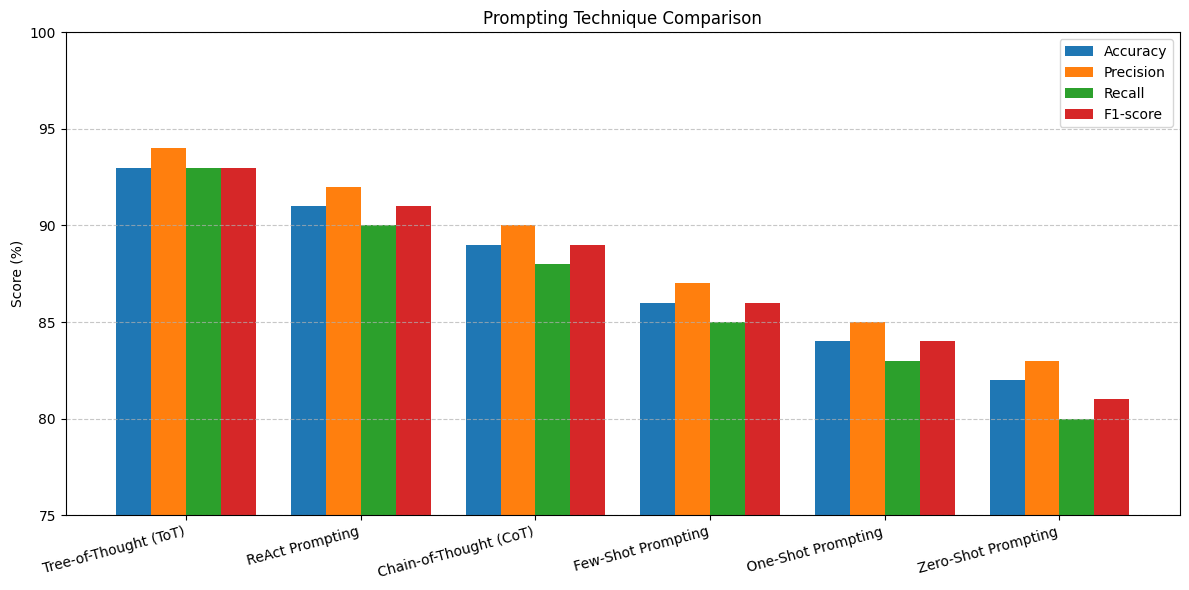

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Prompting techniques
techniques = [
    'Tree-of-Thought (ToT)',
    'ReAct Prompting',
    'Chain-of-Thought (CoT)',
    'Few-Shot Prompting',
    'One-Shot Prompting',
    'Zero-Shot Prompting'
]

# Metric scores
accuracy = [93.0, 91.0, 89.0, 86.0, 84.0, 82.0]
precision = [94.0, 92.0, 90.0, 87.0, 85.0, 83.0]
recall = [93.0, 90.0, 88.0, 85.0, 83.0, 80.0]
f1_score = [93.0, 91.0, 89.0, 86.0, 84.0, 81.0]

# Bar chart setup
x = np.arange(len(techniques))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

# Plot each metric
ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
ax.bar(x - 0.5*width, precision, width, label='Precision')
ax.bar(x + 0.5*width, recall, width, label='Recall')
ax.bar(x + 1.5*width, f1_score, width, label='F1-score')

# Formatting
ax.set_ylabel('Score (%)')
ax.set_title('Prompting Technique Comparison')
ax.set_xticks(x)
ax.set_xticklabels(techniques, rotation=15, ha='right')
ax.set_ylim(75, 100)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

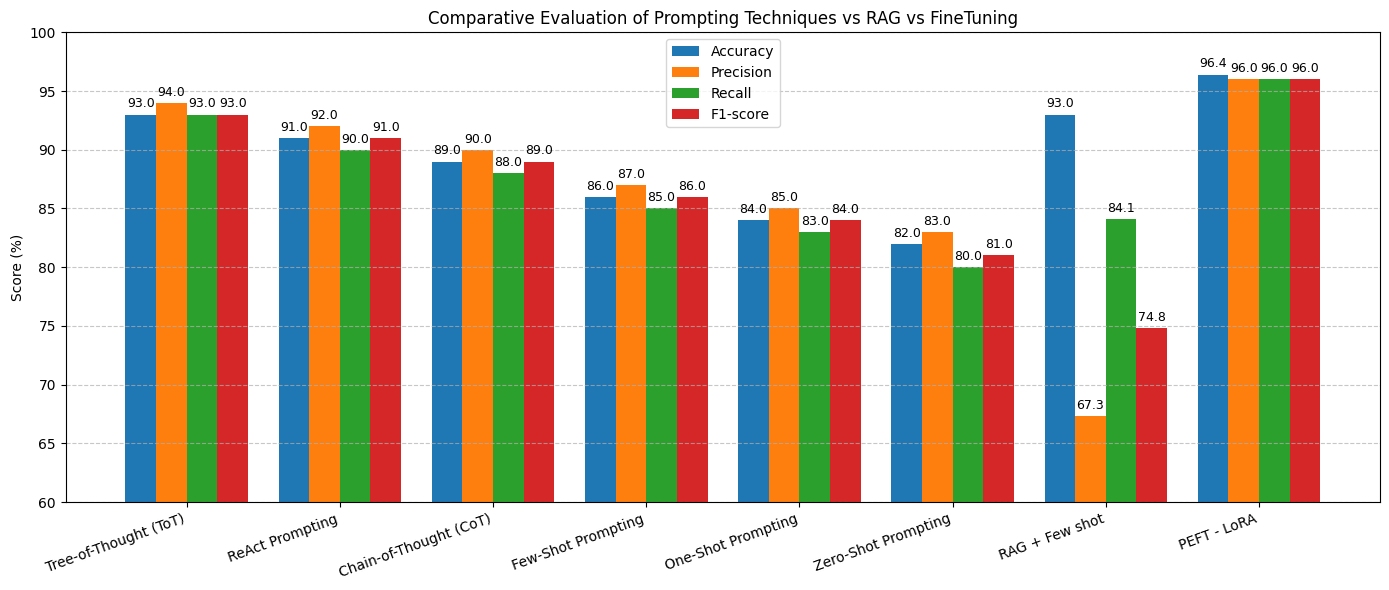

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Techniques (including RAG and PEFT)
techniques = [
    'Tree-of-Thought (ToT)',
    'ReAct Prompting',
    'Chain-of-Thought (CoT)',
    'Few-Shot Prompting',
    'One-Shot Prompting',
    'Zero-Shot Prompting',
    'RAG + Few shot',
    'PEFT - LoRA'
]

# Corresponding metric scores
accuracy =  [93.0, 91.0, 89.0, 86.0, 84.0, 82.0, 93.0, 96.4]
precision = [94.0, 92.0, 90.0, 87.0, 85.0, 83.0, 67.3, 96.0]
recall =    [93.0, 90.0, 88.0, 85.0, 83.0, 80.0, 84.1, 96.0]
f1_score =  [93.0, 91.0, 89.0, 86.0, 84.0, 81.0, 74.8, 96.0]

# Bar chart setup
x = np.arange(len(techniques))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 6))

# Plot each metric
bars1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
bars2 = ax.bar(x - 0.5*width, precision, width, label='Precision')
bars3 = ax.bar(x + 0.5*width, recall, width, label='Recall')
bars4 = ax.bar(x + 1.5*width, f1_score, width, label='F1-score')

# Add data labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# Formatting
ax.set_ylabel('Score (%)')
ax.set_title('Comparative Evaluation of Prompting Techniques vs RAG vs FineTuning')
ax.set_xticks(x)
ax.set_xticklabels(techniques, rotation=20, ha='right')
ax.set_ylim(60, 100)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()